## Analyzing housing prices in Gothenburg region 

In [2092]:
import pandas as pd
import numpy as np
import difflib #find closests string matches
import seaborn as sns
import matplotlib.pyplot as plt

In [2093]:
#load housing prices
df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/hemnet_data.csv', delimiter=';', header=None)
df = df.iloc[:,1:12]
df.columns = ['address', 'house_type', 'solddate', 'soldprice', 'asking_price', 'price_change', 'size', 'rooms', 'monthly_fee', 'agent','url']

In [2094]:
#load additional data to get municipality of each address.
df['municipality']=np.nan

#Update municipality variable. The variable updated accordingly so that the kommune names matches with each other.
municipality_df = pd.read_csv('/Users/navodasenavirathne/Desktop/ML/hemnet/data/municipality.csv', delimiter=';')

for   m in  (municipality_df['Municipality']):
      
      if df['address'].str.contains(m).shape[0] > 0:

            #extract municipality
            df.loc[df['address'].str.contains(m),['municipality'] ]= m
df.head()


,address,house_type,solddate,soldprice,asking_price,price_change,size,rooms,monthly_fee,agent,url,municipality
0,"Vänortsgatan 7 D Mölndal - Bosgården, Mölndals kommun",Apartment,29 05 2022,1450000,1348500.0,7.0,21.0,1,1960.0,Bjurfors,https://www.hemnet.se/salda/lagenhet-1rum-molndal-bosgarden-molndals-kommun-vanortsgatan-7-d-8310438808817469669,Mölndals kommun
1,"Lövmånadsgatan 2 Kortedala, Göteborgs kommun",Apartment,27 05 2022,1050000,987000.0,6.0,25.0,1,1819.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-kortedala-goteborgs-kommun-lovmanadsgatan-2-5796312730465743067,Göteborgs kommun
2,"Järnvägsgatan 22 A Ranten, Falköpings kommun",Apartment,20 05 2022,160000,164800.0,-3.0,23.5,1,1475.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-ranten-falkopings-kommun-jarnvagsgatan-22-a-8623087254402614017,Falköpings kommun
3,"Piltegatan 5A Bosgården, Mölndals kommun",Apartment,20 05 2022,1660000,1676600.0,-1.0,25.0,1,1776.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-bosgarden-molndals-kommun-piltegatan-5a-2292096030999635924,Mölndals kommun
4,"Västmannagatan 11 Norrby, Borås kommun",Apartment,20 05 2022,400000,424000.0,-6.0,25.0,1,1654.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-norrby-boras-kommun-vastmannagatan-11-562131998970867893,Borås kommun


In [2095]:
#encode address and agent variables.
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
df['address']=label.fit_transform(df[['address']])
#df['agent']=label.fit_transform(df[['agent']])
#df.head()

/Users/navodasenavirathne/learn_python/lesson01/.venv/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Fisrt look at the data

Now let's have a look at the dataset we have collected. There are 80231 records and 12 variables.

In [2096]:
df.shape

(80231, 12)

In the next step we are going to consider the entire dataframe and remove any duplicate records that have collected.

In [2097]:
#remove duplicate records.
df = df.drop_duplicates()


The new dataframe now has 63877 records.

In [2098]:
df.shape

(63877, 12)

Next let's see how many records have missing values.

In [2099]:
missing_val = {}
for col in df.columns:
    missing_val[col] = df[col].isna().sum()/df[col].shape[0]

missing_info = pd.DataFrame.from_dict(missing_val,orient='index').reset_index()
missing_info.columns=['Attribute','Missing val %']
missing_info.sort_values(by='Missing val %', inplace=True)
missing_info
   

,Attribute,Missing val %
0,address,0.000000
1,house_type,0.000000
2,solddate,0.000000
3,soldprice,0.000000
6,size,0.000000
7,rooms,0.000000
10,url,0.000000
11,municipality,0.000000
5,price_change,0.044664
9,agent,0.060867


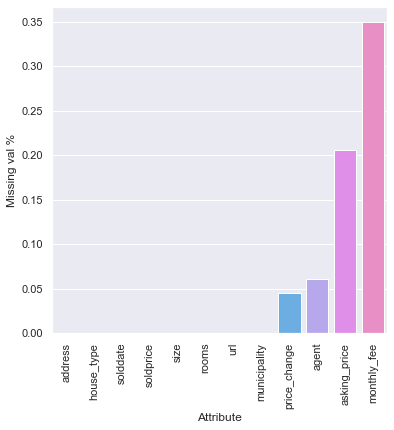

In [2100]:
sns.set(rc = {'figure.figsize':(6,6)})
sns.barplot(x='Attribute', y='Missing val %', data=missing_info)
p = plt.xticks(rotation=90)

As we can observe, out of the 12 variables 4 have missing values. The 'monthly fee' variable has about 38% values missing. 

Next, let's check the data types. Here, we need some updates to variable types.
- Attribute 'solddate' should be converted to a datetype variable.
- Attribute 'soldprice' should be a float variable.
- Attribute address and agent should be object type.

In [2101]:
df.dtypes

address           int64
house_type       object
solddate         object
soldprice         int64
asking_price    float64
price_change    float64
size            float64
rooms            object
monthly_fee     float64
agent            object
url              object
municipality     object
dtype: object

In [2156]:
df['solddate'] = pd.to_datetime(df['solddate'])
df['soldprice'] = df['soldprice'].astype('float64')
df['address'] = df['address'].astype('object')
df['agent'] = df['agent'].astype('object')

In [2103]:
#From solddate variable we extract year and month that will help the analysis better.
df['year'] = pd.DatetimeIndex(df['solddate']).year
df['month'] = pd.DatetimeIndex(df['solddate']).month


In [2104]:
#Identify qualitative and quantitative variables.
quantitative=[]
qualitative=[]

for col in df.columns:
    if df[col].dtypes=='object' or col=='solddate':
        qualitative.append(col)
    else:
        quantitative.append(col)

### Numerical variables

Let's get an idea about the relationships between the numerical variables using the pearson correlation.

<AxesSubplot:>

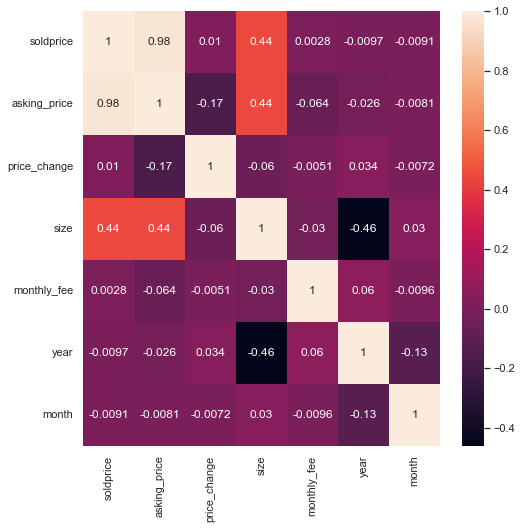

In [2105]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(df[quantitative].corr(),annot=True)

- We can notice a strong positive correlation between the sold price and the asking price. This makes sense as sellers and the real estate agents set an initial price based on the market value of the property.
- The size of the house has a moderately positive correlation with the sale price. 
- The rest of the variables has no significant correlation with the sale price.
- The variable price change indicates whether the final price has increased or descreased compared to the asking price. There is a weak negative correlation noticed between the asking price and the price change. 
- The size is negatively correlated with the year.

Now that we draw some initial conclusions about the relationships among the numerical features we are upadting the dataset as below.
- Impute missing monthly_fee values based on the median value for each house_type.
- Impute missing asking price values.
- Exclude price_change as it can be derived taking the difference between the asking price and sold price.

In [2106]:
#As a start we filter out the records which has a monthly fee value not null or not zero.
mon_df = df[~df['monthly_fee'].isnull() & df['monthly_fee']!=0.0]
mon_df['monthly_fee'].describe()


count    3.182100e+04
mean     4.058410e+03
std      2.917056e+04
min      7.400000e+01
25%      2.776000e+03
50%      3.784000e+03
75%      4.829000e+03
max      5.200000e+06
Name: monthly_fee, dtype: float64

<AxesSubplot:xlabel='house_type', ylabel='monthly_fee'>

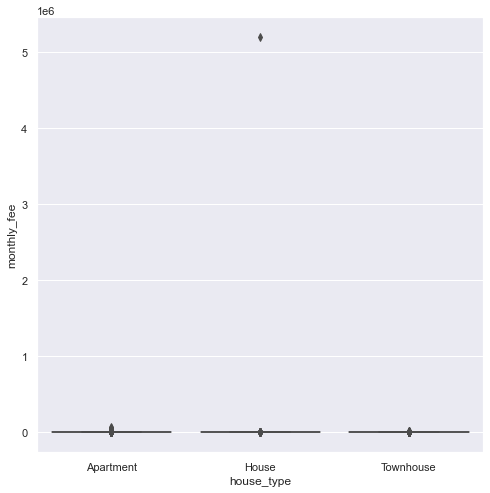

In [2107]:
#Now, let's see how the monthly fee changes based on the house_type
sns.boxplot(x=mon_df['house_type'], y=mon_df['monthly_fee'])

This shows us that their exists an outlier which is exceptionally high. In further investigation this seems like an error in the data collection process (as in this particular instance monthly fee is similar to the soldprice which does not make sense). So we drop this data point.

In [2108]:
#pd.set_option('display.max_colwidth', None)
mon_df.sort_values(by=['monthly_fee'],ascending=False).head(1)

,address,house_type,solddate,soldprice,asking_price,price_change,size,rooms,monthly_fee,agent,url,municipality,year,month
37791,11610,House,2022-01-15,5200000.0,NaN,NaN,102.0,68,5200000.0,Svensk,https://www.hemnet.se/salda/villa-102m2-stockslycke-alingsas-kommun-fyrmastarevagen-6-7134185785231641726,Alingsås kommun,2022,1


In [2109]:
#drop the above record in the original dataframe.
df.drop(index=37791,inplace=True)
df.reset_index(drop=True)

,address,house_type,solddate,soldprice,asking_price,price_change,size,rooms,monthly_fee,agent,url,municipality,year,month
0,48081,Apartment,2022-05-29,1450000.0,1348500.0,7.0,21.0,1,1960.0,Bjurfors,https://www.hemnet.se/salda/lagenhet-1rum-molndal-bosgarden-molndals-kommun-vanortsgatan-7-d-8310438808817469669,Mölndals kommun,2022,5
1,27073,Apartment,2022-05-27,1050000.0,987000.0,6.0,25.0,1,1819.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-kortedala-goteborgs-kommun-lovmanadsgatan-2-5796312730465743067,Göteborgs kommun,2022,5
2,19402,Apartment,2022-05-20,160000.0,164800.0,-3.0,23.5,1,1475.0,Fastighetsbyrån,https://www.hemnet.se/salda/lagenhet-1rum-ranten-falkopings-kommun-jarnvagsgatan-22-a-8623087254402614017,Falköpings kommun,2022,5
3,32420,Apartment,2022-05-20,1660000.0,1676600.0,-1.0,25.0,1,1776.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-bosgarden-molndals-kommun-piltegatan-5a-2292096030999635924,Mölndals kommun,2022,5
4,48454,Apartment,2022-05-20,400000.0,424000.0,-6.0,25.0,1,1654.0,HusmanHagberg,https://www.hemnet.se/salda/lagenhet-1rum-norrby-boras-kommun-vastmannagatan-11-562131998970867893,Borås kommun,2022,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63871,32430,House,2013-06-02,4500000.0,3825000.0,15.0,220.0,8,NaN,Fastighetsbyrån,https://www.hemnet.se/salda/villa-8rum-stenungsund-stenungsunds-kommun-pilvagen-3-35394,Stenungsunds kommun,2013,6
63872,19435,House,2013-05-02,2000000.0,2360000.0,-18.0,200.0,8,NaN,Fastighetsbyrån,https://www.hemnet.se/salda/villa-8rum-ekudden-mariestads-kommun-jarnaldersvagen-11-35292,Mariestads kommun,2013,5
63873,33117,House,2013-01-31,2950000.0,3274500.0,-11.0,206.0,9,NaN,Fastighetsbyrån,https://www.hemnet.se/salda/villa-9rum-gamla-staden-lidkopings-kommun-prastgardsgatan-8-34954,Lidköpings kommun,2013,1
63874,20816,House,2013-01-29,1600000.0,1760000.0,-10.0,200.0,9,NaN,Fastighetsbyrån,https://www.hemnet.se/salda/villa-9rum-skultorp-skovde-kommun-klagstorpsvagen-22-34790,Skövde kommun,2013,1


<AxesSubplot:xlabel='house_type', ylabel='monthly_fee'>

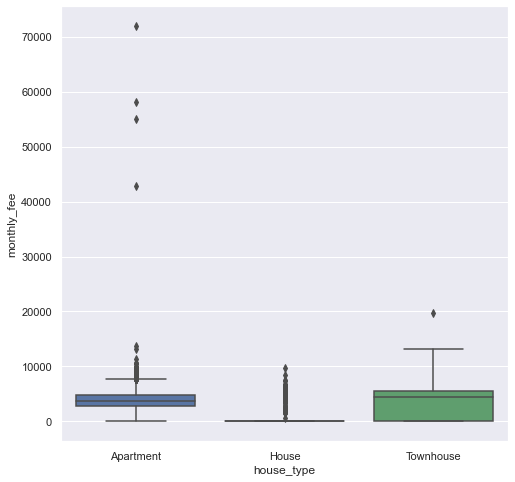

In [2110]:
mon_df = df[~df['monthly_fee'].isnull() | df['monthly_fee']!=0.0]
mon_df['monthly_fee'].describe()
sns.boxplot(x=mon_df['house_type'], y=mon_df['monthly_fee'])

In [2111]:
for h in df['house_type'].unique():
    h_med = df[df['house_type']==h]['soldprice'].median()
    df.loc[ (df['house_type'] == h) & ((df['monthly_fee'].isna()) | (df['monthly_fee'] == 0.0)),'monthly_fee'] = h_med

In [2112]:
missing_val={}
for col in df.columns:
    missing_val[col] = df[col].isna().sum()/df[col].shape[0]
print(missing_val)

{'address': 0.0, 'house_type': 0.0, 'solddate': 0.0, 'soldprice': 0.0, 'asking_price': 0.20607113782954475, 'price_change': 0.04464900745193813, 'size': 0.0, 'rooms': 0.0, 'monthly_fee': 0.0, 'agent': 0.060867931617508926, 'url': 0.0, 'municipality': 0.0, 'year': 0.0, 'month': 0.0}


In [2113]:
#interpolate missing asking price values
df['asking_price'].interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)

The new correlation matrix looks like below.

<AxesSubplot:>

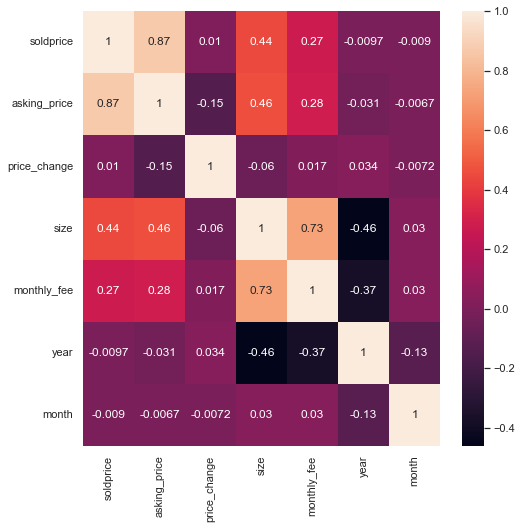

In [2114]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(df[quantitative].corr(),annot=True)

Most significant change we can notice is between the year and the monthly_fee variables after the data imputation. Which indicates as the years progress monthly fee seems to have declined.

### Categorical/Nominal variables

We drop all the records with missing agent values as they are only a few and exclude rooms and URL. Rooms variable is excluded due to an error in data collection.

In [2115]:
df = df[['address', 'house_type', 'solddate', 'soldprice', 'asking_price', 'size', 'monthly_fee', 'agent', 'municipality',  'year', 'month']]

In [2116]:
#drop records with missing agent.
df = df[~df['agent'].isna()]
df.reset_index(drop=True)
df

,address,house_type,solddate,soldprice,asking_price,size,monthly_fee,agent,municipality,year,month
0,48081,Apartment,2022-05-29,1450000.0,1348500.0,21.0,1960.0,Bjurfors,Mölndals kommun,2022,5
1,27073,Apartment,2022-05-27,1050000.0,987000.0,25.0,1819.0,Fastighetsbyrån,Göteborgs kommun,2022,5
2,19402,Apartment,2022-05-20,160000.0,164800.0,23.5,1475.0,Fastighetsbyrån,Falköpings kommun,2022,5
3,32420,Apartment,2022-05-20,1660000.0,1676600.0,25.0,1776.0,HusmanHagberg,Mölndals kommun,2022,5
4,48454,Apartment,2022-05-20,400000.0,424000.0,25.0,1654.0,HusmanHagberg,Borås kommun,2022,5
...,...,...,...,...,...,...,...,...,...,...,...
80226,32430,House,2013-06-02,4500000.0,3825000.0,220.0,3300000.0,Fastighetsbyrån,Stenungsunds kommun,2013,6
80227,19435,House,2013-05-02,2000000.0,2360000.0,200.0,3300000.0,Fastighetsbyrån,Mariestads kommun,2013,5
80228,33117,House,2013-01-31,2950000.0,3274500.0,206.0,3300000.0,Fastighetsbyrån,Lidköpings kommun,2013,1
80229,20816,House,2013-01-29,1600000.0,1760000.0,200.0,3300000.0,Fastighetsbyrån,Skövde kommun,2013,1


In this case we are trying to findout whether there are any associations between the numerical variables and the categorical variables like house_type, agent, municipality. To see whether any association exists we are using anova test. Here,
    - H0 - There are no associations between the variables.
    - H1- There is an association between the variables.
We reject the null hypothesis if the p val is less than 0.005.

To compute the association between the categorical variables we are using Cramer's V. The obtained value ranges from 0 to 1 where 0 indiacates no association and 1 indicates a strong association.

In [2117]:
#update qualitative variable list removing address, rooms and url
qualitative = ['house_type',  'agent', 'municipality','year', 'month']

In [2118]:
#encode categorical variables to numbers.
from sklearn import preprocessing

#copy original dataframe
catdf = df.copy(deep=True)
catdf = df[qualitative]

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in catdf.columns :
  data_encoded[i]=label.fit_transform(catdf[i])

print(data_encoded.head(5))

   house_type  agent  municipality  year  month
0           0      6            26     9      4
1           0     22            11     9      4
2           0     22             7     9      4
3           0     32            26     9      4
4           0     32             4     9      4


In [2119]:
import scipy.stats as stats
def cramersV(data_encoded):
   rows, prows = [], []
   for col_o in data_encoded.columns:
       col, pcols = [], []
       for col_i in data_encoded.columns:
        cont_tab = pd.crosstab(index=data_encoded[col_o],columns=data_encoded[col_i],rownames=None, colnames=None)
        chi, p, _, _ = stats.chi2_contingency(cont_tab)
        r = cont_tab.shape[0]
        c = cont_tab.shape[1]
        n = data_encoded.shape[0] #np.sum(cont_tab.values) #data_encoded.shape[0]

        min_val = min(r-1,c-1)
        phi_val = chi / n
        
        v = np.sqrt( phi_val/ min_val )
        col.append(round(v,2))
        pcols.append(p)

       rows.append(col)
       prows.append(pcols)

  
   cramers_results = np.array(rows)
   cramers_matix = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

   sig_results = np.array(prows)
   sig_matix = pd.DataFrame(sig_results, columns = data_encoded.columns, index =data_encoded.columns)
   return cramers_matix, sig_matix

In [2120]:
cramers_matix, sig_matix = cramersV(data_encoded)

In [2121]:
#If p < 0.05 that means an association exists between the variables.
sig_matix


,house_type,agent,municipality,year,month
house_type,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.294931e-34
agent,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.244132e-14
municipality,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.412259e-31
year,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
month,2.294931e-34,1.244132e-14,1.412259e-31,0.0,0.000000e+00


This indicates that all the categorical variables are associated with each other. However, this does not quantify the strength of the association. For that we use Cramer's V which gives us a values ranging from 0-1 indicating the strength of the association.

In [2122]:
#cramer's V values
cramers_matix

,house_type,agent,municipality,year,month
house_type,1.00,0.26,0.36,0.28,0.04
agent,0.26,1.00,0.27,0.11,0.04
municipality,0.36,0.27,1.00,0.07,0.04
year,0.28,0.11,0.07,1.00,0.10
month,0.04,0.04,0.04,0.10,1.00


The above data indicates a weak associations between the categorical variables.

<AxesSubplot:>

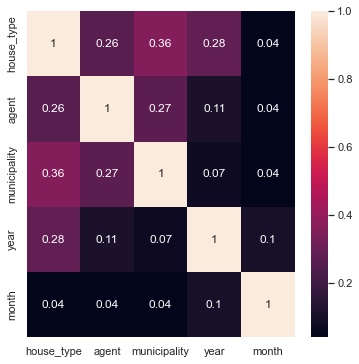

In [2123]:
sns.set(rc = {'figure.figsize':(6,6)})
sns.heatmap(cramers_matix,annot=True)

## Exploratory data analysis

In this section we are trying to draw interesting insights from our data that can help buyers, sellers and the real estate agents in the decision making processes.

### House type

In [2124]:
#What are the average sale prices and the count for different house types? aprtments 2.6mn, house 3.7mn, and townhouse 3.8mn
df.groupby('house_type')['soldprice'].agg(['mean','count'])

,mean,count
house_type,,
Apartment,2.667682e+06,29425
House,3.710570e+06,25107
Townhouse,3.887299e+06,5456


 <font color='blue'>The above data show us an overview of the property sales in Västra Götaland region. We an see that most sales happend with respect to apartments followed by houses. The average sale prices for apartments, houses, and townhoues are respectively 2.66mn, 3.7mn, and 3.88mn SEK.</font> 

Text(0, 0.5, 'Average sale price')

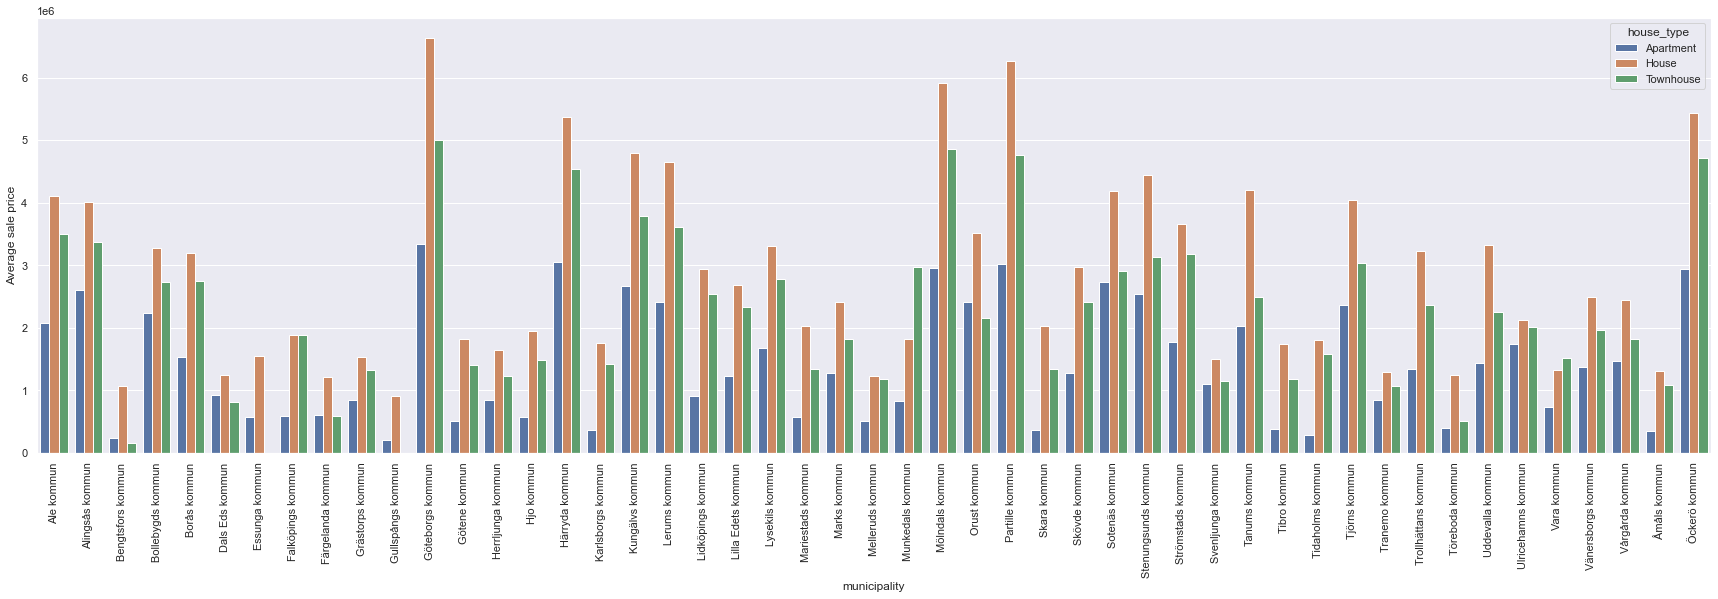

In [2125]:
#Find the average sale price for different house type for each municipality.
sale_info_df = df.groupby(['house_type','municipality']).agg('mean')['soldprice'].reset_index()

sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x=sale_info_df['municipality'], y=sale_info_df['soldprice'], hue=sale_info_df['house_type'])
a=plt.xticks(rotation=90)
plt.ylabel("Average sale price")


 <font color='blue'>The highest average aprtment,house, and townhouse prices are reported in the Goteborgs municipality. </font>

### Housing size


In [2126]:
#What is the avearge sizes for different housing types.
df.groupby(['house_type'])['size'].mean()

house_type
Apartment     65.753407
House        139.238846
Townhouse    120.778262
Name: size, dtype: float64

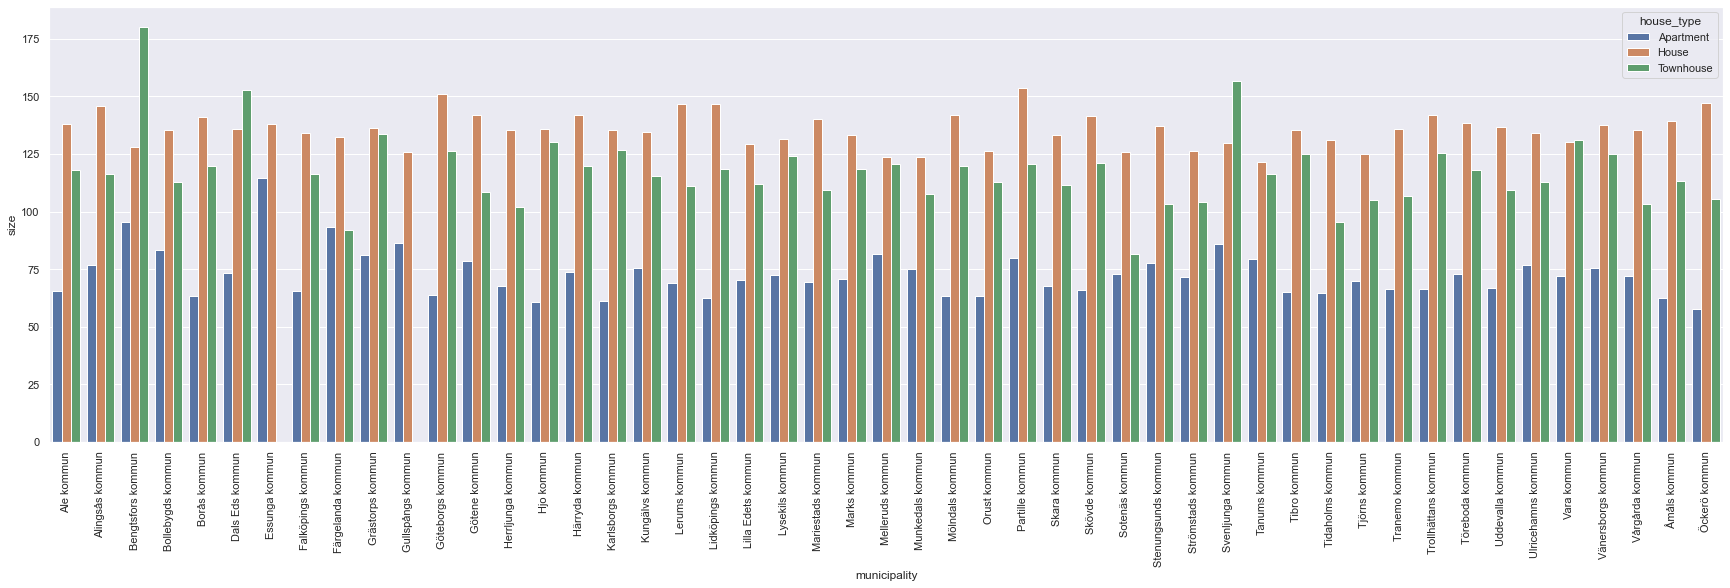

In [2127]:
#How average housing sizes changes per municipality
size_mun_df = df.groupby(['house_type','municipality'])['size'].mean().reset_index()

sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x='municipality',y='size',hue='house_type',data=size_mun_df)
a=plt.xticks(rotation=90)

<font color='blue'>Highest average apartment, house, and townhouse sizes are reported respectively by Essunga, Partille, and Bengsfors municipalities.</font>

### Municipality

In [2128]:
#Which municipalities have above average aprtment, house, and townhouse prices?

#fisrt compute average prices
avg_tot_dict = dict(df.groupby('house_type').mean()['soldprice'])
avg_tot_dict

{'Apartment': 2667681.765675446,
 'House': 3710569.707611423,
 'Townhouse': 3887299.463526393}

In [2129]:
#Municipalities with above average apartment prices
avg_sales = sale_info_df.groupby(['municipality','house_type']).mean().reset_index()
abv_avg_aprt = avg_sales[(avg_sales['house_type']=='Apartment') & (avg_sales['soldprice'] > avg_tot_dict['Apartment'] ) ]['municipality'].to_list()

#Municipalities with above average house prices
abv_avg_hus = avg_sales[(avg_sales['house_type']=='House') & (avg_sales['soldprice'] > avg_tot_dict['House'] ) ]['municipality'].to_list()

#Municipalities with above average townhouse prices
abv_avg_thus = avg_sales[(avg_sales['house_type']=='Townhouse') & (avg_sales['soldprice'] > avg_tot_dict['Townhouse'] ) ]['municipality'].to_list()

list(set(abv_avg_aprt) & set(abv_avg_hus) & set(abv_avg_thus) )


['Partille kommun',
 'Mölndals kommun',
 'Öckerö kommun',
 'Göteborgs kommun',
 'Härryda kommun']

<font color='blue'>The above results shows that in Göteborgs, Härryda, Mölndals, Partille, Sotenäs, and  Öckerö municipalities the average housing prices (houses, apartments, townhouses) are higher than the average housing prices in the region.<font color='blue'>

In [2130]:
#Compute the number of aprtments, houses, and townhouses sold municipality wise.
house_count_df = df.groupby(['municipality', 'house_type']).count()['solddate'].reset_index()
house_count_df.columns = ['municipality', 'house_type','count']
house_count_df

,municipality,house_type,count
0,Ale kommun,Apartment,442
1,Ale kommun,House,823
2,Ale kommun,Townhouse,192
3,Alingsås kommun,Apartment,640
4,Alingsås kommun,House,806
...,...,...,...
140,Åmåls kommun,House,320
141,Åmåls kommun,Townhouse,32
142,Öckerö kommun,Apartment,85
143,Öckerö kommun,House,226


Text(0, 0.5, 'Count')

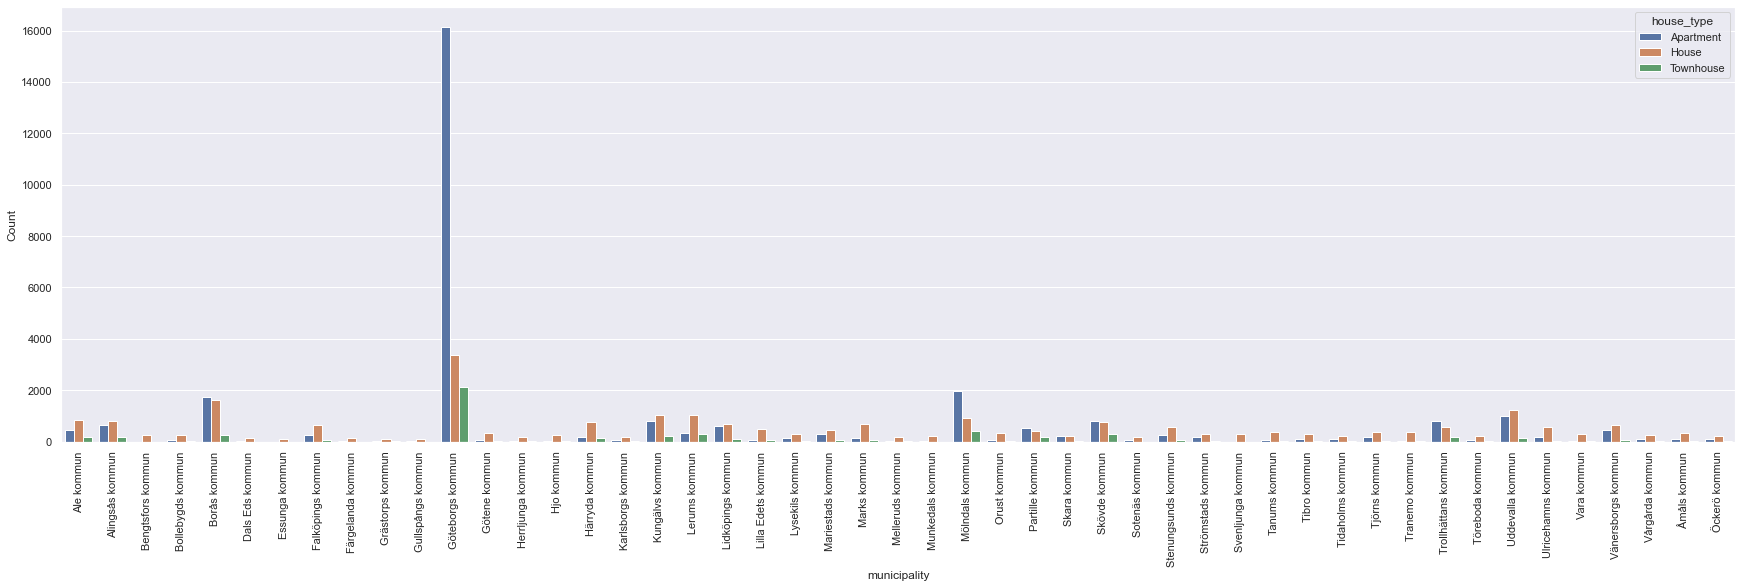

In [2131]:
sns.set(rc = {'figure.figsize':(30,8)})
sns.barplot(x=house_count_df['municipality'], y=house_count_df['count'], hue=house_count_df['house_type'])
a=plt.xticks(rotation=90)
plt.ylabel("Count")


<font color='blue'>As depicted by the above figure the highest number of sales has occured in the Göteborgs municipality with respect to all housing types.</font>

In [2132]:
#Compute the total number of sales in each municipality as a percentage of the total sale count.
sns.set(rc = {'figure.figsize':(10,8)})
perct_df = pd.DataFrame(df.groupby('municipality')['soldprice'].count() / df.shape[0]).reset_index().sort_values(by='soldprice', ascending=False)
perct_df.columns = ['municipality','sale percentage']
#perct_df

<AxesSubplot:xlabel='sale percentage', ylabel='municipality'>

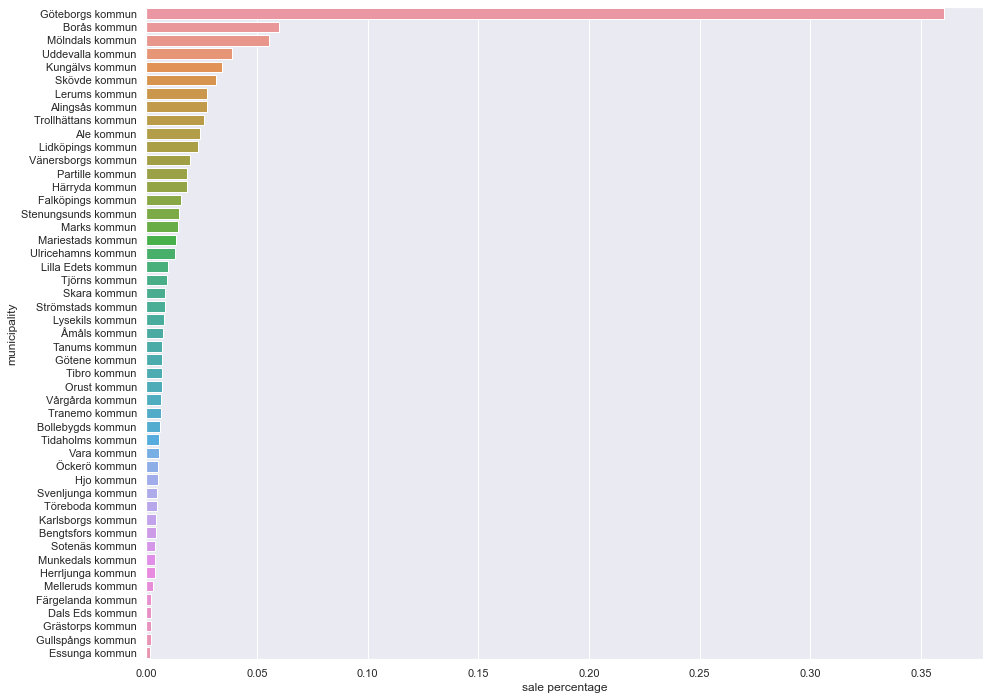

In [2133]:
sns.set(rc = {'figure.figsize':(15,12)})
sns.barplot(x='sale percentage',y='municipality', data=perct_df)

### Address

 The above graph vizualizes that majority of the sales occur at Göteborgs municipality followed by Borås. However, these sales may include multiple sales of the same property over the years. In the next step let's look at how many of these sales are with respect to unique properties. In order to get unique properties we filter from the address.

In [2134]:
#How many properties are sold more than 1 time.
freq_sale_df = df.groupby('address').count()['house_type'].reset_index().sort_values(by='house_type', ascending=False)
freq_sale_df.columns = ['address','frequency']
freq_sale_df[freq_sale_df['frequency']>1].shape[0]

6068

We can notice that that there are 6068 properties that are sold more than one time.

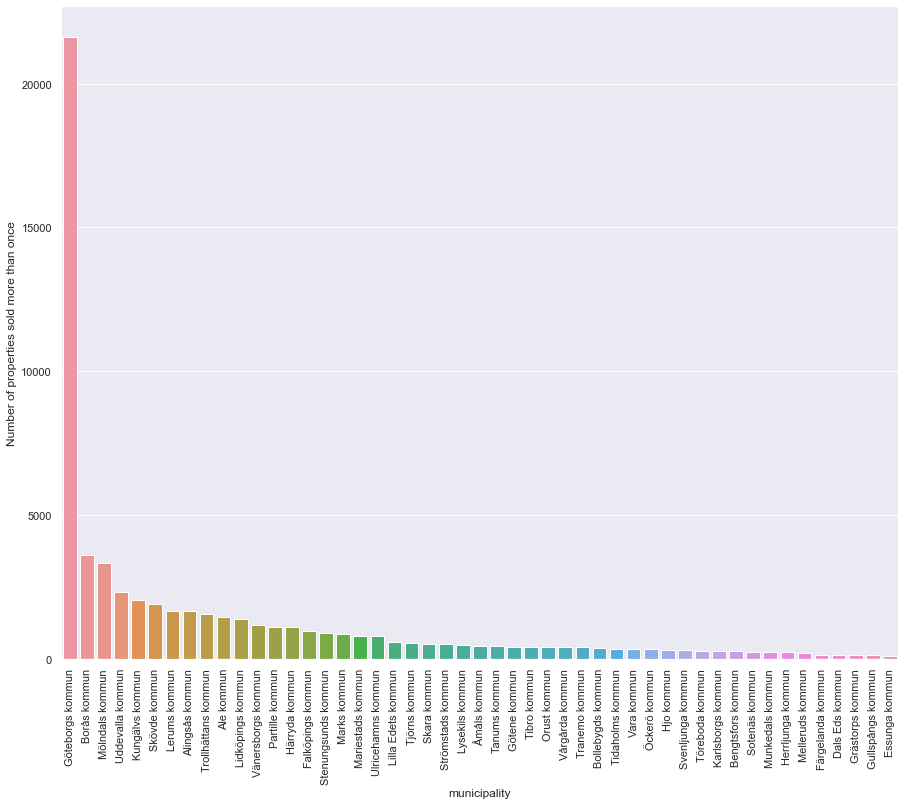

In [2135]:
#In which municipalities the property resales are the most and the least?
freq_sale_df = df.groupby(['address','municipality','house_type']).count()['soldprice'].reset_index()
freq_sale_df.columns = ['address','municipality','house_type','frequency']
freq_sale_df = freq_sale_df[freq_sale_df['frequency']>1]
freq_sale_df = df.groupby(['municipality']).count()['house_type'].reset_index()
freq_sale_df.columns = ['municipality','Number of properties sold more than once']
freq_sale_df = freq_sale_df.sort_values(by='Number of properties sold more than once', ascending=False)
sns.barplot(x='municipality',y='Number of properties sold more than once',data=freq_sale_df)
a=plt.xticks(rotation=90)


<font color='blue'>So we can see that in Goteborgs community house resales are the highest.</font>

### Monthly fee

Montly fee or Avgift in Swedish is a fixed payment you have to pay for the house monthly.

<AxesSubplot:xlabel='house_type', ylabel='monthly_fee'>

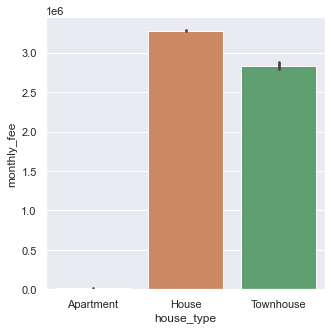

In [2136]:
#How is the monthly fee changes per house type.
sns.set(rc = {'figure.figsize':(5,5)})
sns.barplot(y='monthly_fee',x='house_type',data=df)

<font color='blue'>As per the above illustration we can notice that monthly fee changes drastically based on the housing type.</font> 

### Real estate agents

In [2137]:
#Which agent has carried out the maximum sales.
agent_df = df.groupby('agent')['house_type'].count().to_frame().reset_index().sort_values(by='house_type', ascending=False)

Text(0, 0.5, 'Total sales')

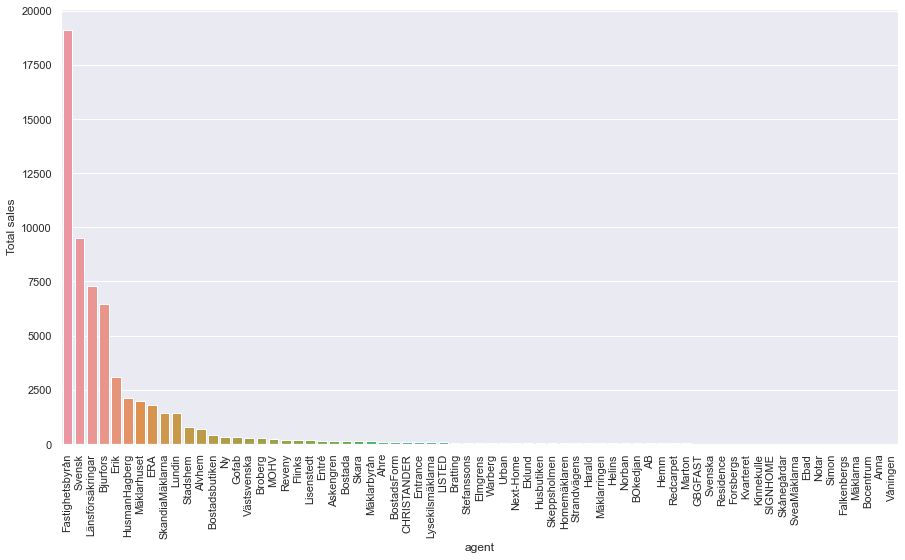

In [2138]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='agent',y='house_type',data=agent_df)
a=plt.xticks(rotation=90)
plt.ylabel('Total sales')

In [2139]:
#Which agents has the highest/lowest municipality wise coverage.
agent_df = df.groupby(['agent','municipality'])['house_type'].count().reset_index()
agent_df = agent_df.groupby(['agent']).count()['municipality'].reset_index().sort_values(by='municipality', ascending=False)


Text(0, 0.5, 'Number of municipalities')

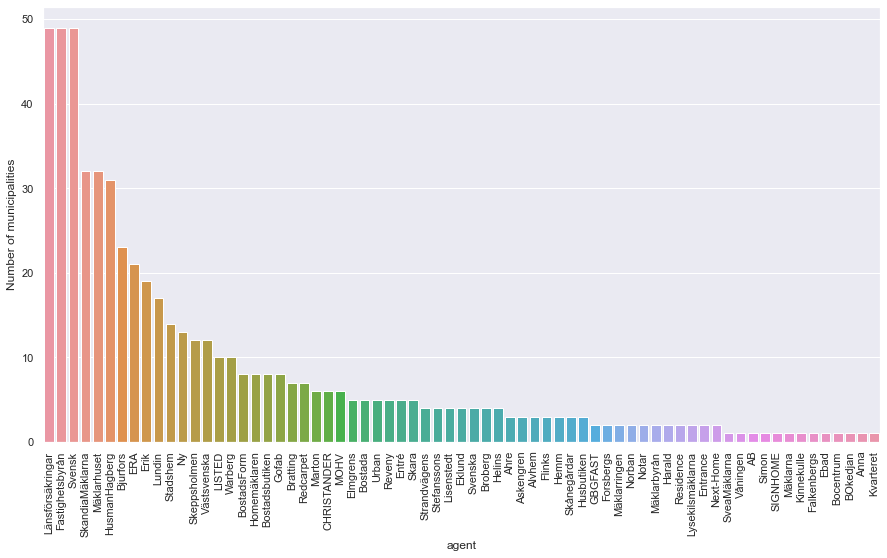

In [2140]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.barplot(x='agent',y='municipality',data=agent_df)
a=plt.xticks(rotation=90)
plt.ylabel('Number of municipalities')

<font color='blue'>We can see there are three agents that operates in all the municipalities. Out of them one agent is far ahed from the other two in number of sales.</font>

### Month

Text(0, 0.5, 'Number of sales')

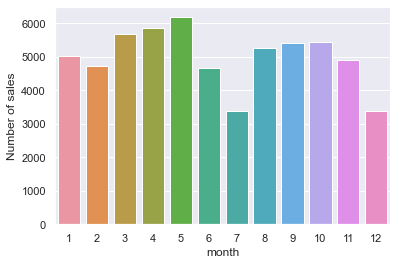

In [2141]:
#Which months of the year has most of the housing sales?

perc_monthly = df.groupby('month')['solddate'].count().reset_index()
sns.set(rc = {'figure.figsize':(6,4)})
sns.barplot(x='month',y='solddate',data=perc_monthly)
plt.ylabel('Number of sales')

## Bivaraiate analysis

In this section we explore the relationships among the variables and vizualize them.

### Yearly sales vs price

Let's try to get an idea how yearly  sales has changed.

In [2142]:
#How is the average sale prices has changed for different properties yearly.
df = df.sort_values(by='year')
yearly_sales = df.groupby(['year','house_type'])['soldprice'].mean().reset_index()

<AxesSubplot:xlabel='year', ylabel='soldprice'>

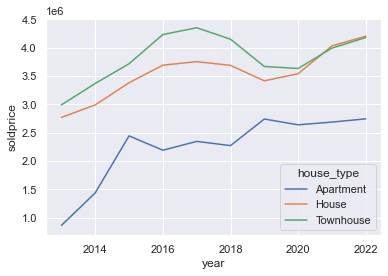

In [2143]:
sns.set(rc = {'figure.figsize':(6,4)})
sns.lineplot(x='year',y='soldprice',data=yearly_sales,hue='house_type')

<font color='blue'>The above figure depicts that as the years pass the housing prices has increased cocerning all housing types. Next, we'll have a look at the same data but with respect to Göteborgs municipality.</font>

Text(0, 0.5, 'Number of sales')

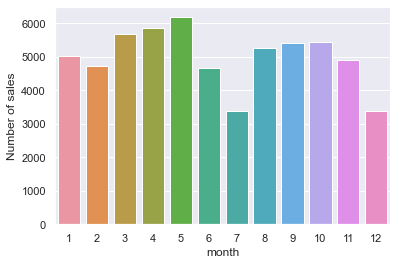

In [2144]:
#Which months of the year has most of the housing sales?

perc_monthly = df.groupby('month')['solddate'].count().reset_index()
sns.set(rc = {'figure.figsize':(6,4)})
sns.barplot(x='month',y='solddate',data=perc_monthly)
plt.ylabel('Number of sales')

<font color='blue'>We can see that most sales happen in the period of March to May (Spring). This is understandable as people may buy the houses right before the summer so that they can move during the summer. (It is unlikely that people get to move right away to a new house. Usually there is a waiting period about 1-3 months). We can see that the least activity happens during the months of June, July (summer), and December (Christmas/ holiday). Moreover, the period of August to October also seems to be faviurable for sales.</font>

### Sale price vs Monthly fee


[None]

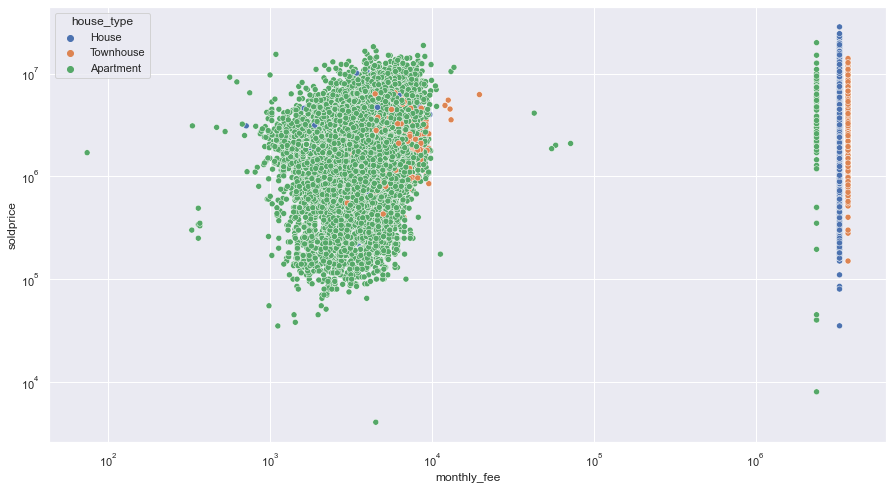

In [2145]:
sns.set(rc = {'figure.figsize':(15,8)})
graph=sns.scatterplot(x='monthly_fee',y='soldprice',hue='house_type',data=df)
graph.set(yscale='log')
graph.set(xscale='log')



In [2146]:
np.corrcoef(df['monthly_fee'],df['soldprice'])

array([[1.        , 0.27058904],
       [0.27058904, 1.        ]])

<font color='blue'> A weak positive correlation between sale prices and the monthly fee variables can be noticed. Further, in the right corner of the above figure we can observe that there exists a set of different housing types with very high monthly fee reported for a wide range of sale prices.</font>

Next we'll have a closer look at the data points in the right most corner of the above figure.

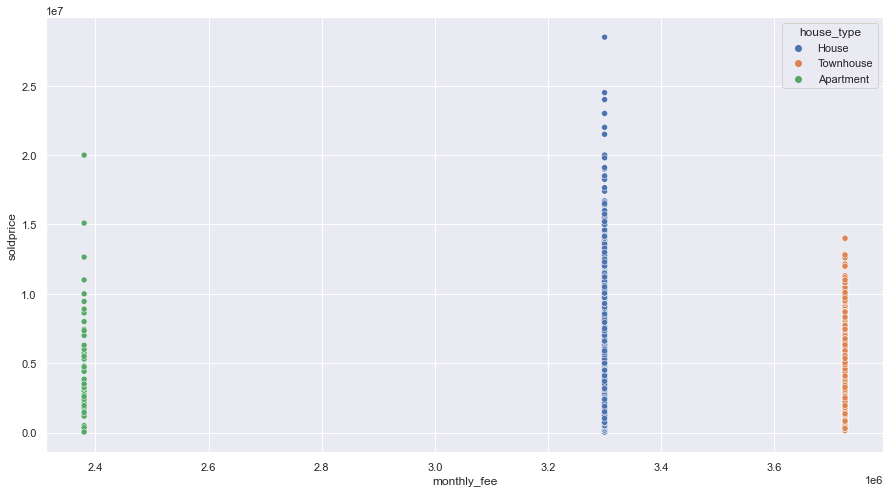

In [2147]:
sns.set(rc = {'figure.figsize':(15,8)})
graph=sns.scatterplot(x='monthly_fee',y='soldprice',hue='house_type',data=df[df['monthly_fee']>100000])
#graph.set(yscale='log')
#graph.set(xscale='log')


In [2148]:
#Which house types are more likely to have this very high monthly payments?
hdf= df[df['monthly_fee']>100000]
hdf.groupby(['house_type']).count()['soldprice']

house_type
Apartment       79
House        24954
Townhouse     4152
Name: soldprice, dtype: int64

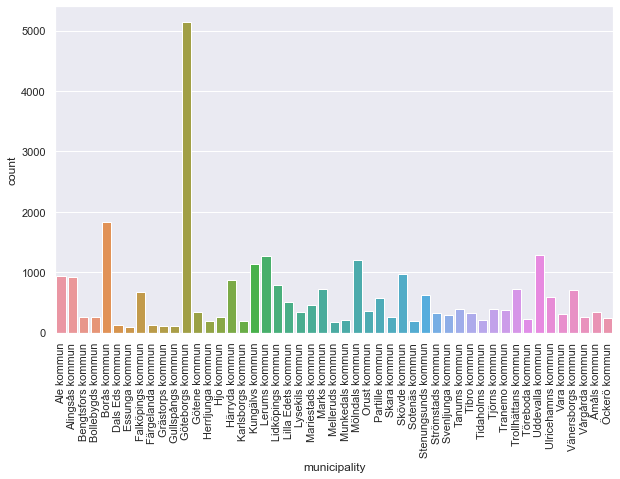

In [2149]:
sns.set(rc = {'figure.figsize':(10,6)})
mdf = hdf.groupby('municipality').count()['soldprice'].reset_index()
mdf.columns = ['municipality','count']
sns.barplot(x='municipality',y='count',data=mdf)
a=plt.xticks(rotation=90)

<font color='blue'> From the above analysis, we can conclude that out of the properties that have reported very high monthly fees (monthly fee > 100000sek) 85.5% are houses. Also, we can see that out of the aforementioned properties with very high monthly fees about 17.6% are located in the Goteborgs municipality. Given that Goteborgs municipality includes Goteborg city which is a highly urburn area and the capital of the region these high prices are explainable. </font> 

### Sale price vs Size

[None]

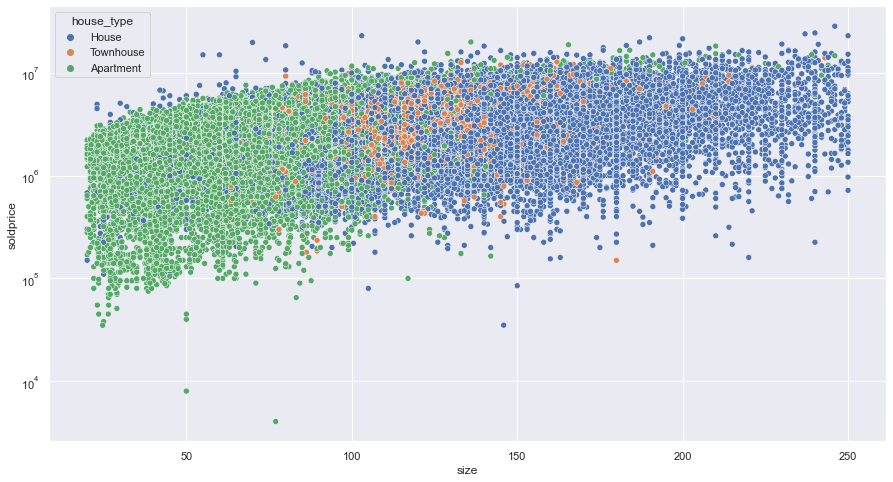

In [2150]:
sns.set(rc = {'figure.figsize':(15,8)})
graph=sns.scatterplot(y='soldprice',x='size',hue='house_type',data=df)
graph.set(yscale='log')


In [2151]:
np.corrcoef(df['size'],df['soldprice'])

array([[1.        , 0.44872345],
       [0.44872345, 1.        ]])

<font color='blue'> There are many variables that can affect the price of a house. One of the most dominant out of them is the size of the house. From the below figure we can notice that the price and the size are positively corrrelated (0.448). Which means higher prices are reported for larger houses. This seems to be the case for all three types of houses.</font>

Here, we can explore how the moderate positve correlation between the aforementioned variables changes based on the house type.

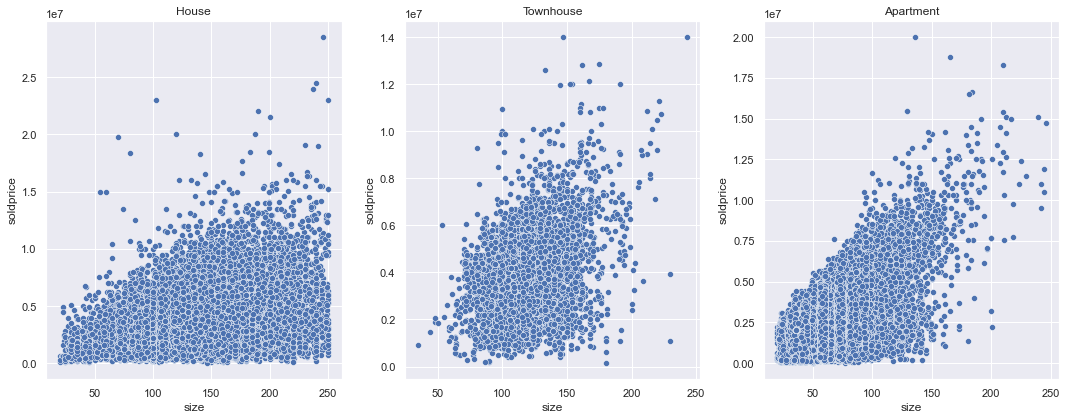

In [2152]:
sns.set(rc = {'figure.figsize':(15,6)})
fig, axes = plt.subplots(1,3)
sns.scatterplot(x='size',y='soldprice',data=df[df['house_type']=='House'],ax=axes[0]).set(title= "House" )
sns.scatterplot(x='size',y='soldprice',data=df[df['house_type']=='Townhouse'],ax=axes[1]).set(title= "Townhouse")
sns.scatterplot(x='size',y='soldprice',data=df[df['house_type']=='Apartment'],ax=axes[2]).set(title= "Apartment" )
plt.tight_layout()

In [2153]:
for h in df['house_type'].unique():
    cor = np.corrcoef(df[df['house_type']==h]['size'], df[df['house_type']==h]['soldprice'])[0][1] 
    print("Correlation between price and size for ", h, " is : ", cor)


Correlation between price and size for  House  is :  0.3214633839022221
Correlation between price and size for  Townhouse  is :  0.3458525898204588
Correlation between price and size for  Apartment  is :  0.5409374132223453


<font color='blue'>Compred to the other property types the apartment prices have a significant impact from the size.</font>

### Sale price vs asking price

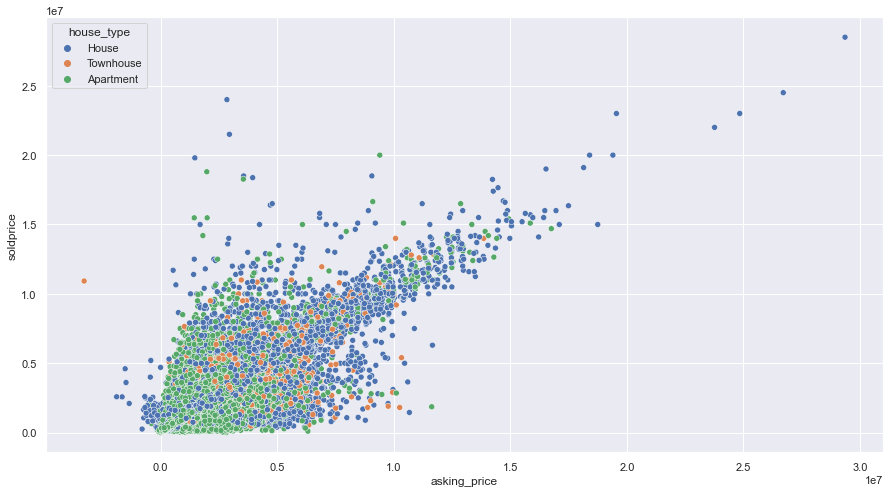

In [2154]:
sns.set(rc = {'figure.figsize':(15,8)})
graph=sns.scatterplot(y='soldprice',x='asking_price',hue='house_type',data=df)


In [2155]:
np.corrcoef(df['asking_price'], df['soldprice'])


array([[1.        , 0.86872903],
       [0.86872903, 1.        ]])

<font color='blue'>The two variables, asking price and sale prices are strongly correlated as expected. With respect to these two variables an interesting question answer will be which houses are sold for a higher or a lower price than the asking price.</font>